# Neural Networks

This notebook contains the code, results, and interpretation of fitting a neural network to predict the pathological response of a cohort of 49 patients with locally advanced rectal cancer.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns

tf.random.set_seed(42)

In [3]:
if not os.path.exists('results/02_NeuralNetwork'):
    os.makedirs('results/02_NeuralNetwork')

## Data reading
The selected data is read according to the results from the notebook `01_variable_selection`, which contain 39 cases labeled as `1` for non-complete response and 10 cases labeled as `0` for complete response.


In [4]:
# Read data and get response
data = pd.read_csv("data/selected_features.csv")
response = data['response']
data = data.drop(['response'], axis=1)
data.head()

,VolumeNum,GrayLevelNonUniformityNormalized.1,Elongation,InterquartileRange,SizeZoneNonUniformityNormalized,SmallAreaEmphasis,Strength,SurfaceVolumeRatio,Edad,Genero,Localización,N_clinico,Invasion_mesorecto,CEA_basal
0,1,0.026988,0.511936,197.0,0.444987,0.693348,0.882716,0.134019,64,0,0,1,1,0
1,1,0.061615,0.700567,111.0,0.328651,0.592024,1.579438,0.145663,72,0,1,2,1,0
2,1,0.043117,0.728945,97.0,0.397054,0.654634,2.444571,0.133402,68,0,0,1,0,1
3,1,0.026388,0.861587,802.0,0.541238,0.763957,0.398438,0.097681,65,0,1,0,0,0
4,1,0.032382,0.776489,111.0,0.436163,0.686958,0.987403,0.119279,72,1,1,1,0,0


## *Oversampling* using SMOTE

Using the SMOTE technique, oversampling of the minority category will be performed to balance both categories in the response variable. This technique involves synthesizing new data for the minority category from existing data by using an interpolation algorithm between neighboring points. This approach increases the number of data points in the minority category without directly duplicating them, which helps improve the model's performance in classifying that category.

In [5]:
# Oversample data (repeat until no NA is produced)
smote = SMOTE(random_state=666, k_neighbors=6)
while True:
    data, response = smote.fit_resample(data, response)
    idx_na = data.isna().any(axis=1)
    if idx_na.any():
        data = data.loc[~ idx_na, :].reset_index(drop=True)
        response = response[~ idx_na].reset_index(drop=True)
    else:
        break
# Check that the oversampling has worked
print(Counter(response))

Counter({1: 39, 0: 39})



After performing the oversampling, an exploratory PCA is conducted to verify that the structure of the data has been maintained.

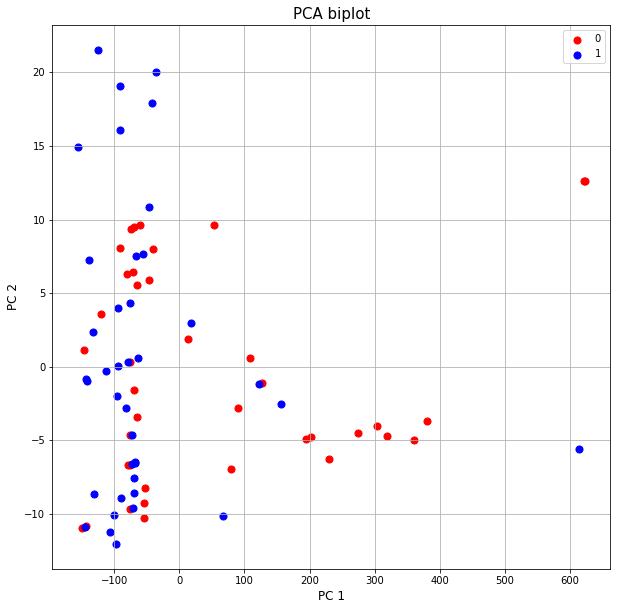

In [6]:
# Fit PCA to see data structure
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data, columns=data.columns)

# PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_scaled)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2'])
pca_fit_df['response'] = response

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

## Ajuste de la red neuronal

First, the data is split into training and test subsets with a 0.75:0.25 ratio. This ensures that the model is trained on a significant amount of data while having an independent dataset available to evaluate its performance later. This division is a common practice in machine learning, as it provides a reliable estimate of the model's generalization to new, unseen data during training.


In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data, response,
                                                    random_state = 123,
                                                    test_size = 0.25)


The neural network was trained on the scaled data. The proposed neural network architecture is a feedforward neural network with three dense layers. The first layer has 64 neurons with a ReLU activation function, processing the input training data. The second layer has 32 neurons, also with a ReLU activation function, extracting more abstract features. The third layer has one neuron with a sigmoid activation function, producing a binary output.

The neural network is trained using binary cross-entropy loss and the Adam optimizer with a learning rate of 0.001. Accuracy is used as the evaluation metric during training. Additionally, early stopping is employed to prevent overfitting, stopping training when validation loss does not improve for 5 consecutive epochs


In [8]:
# Fit Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping],
                    verbose=0, shuffle=False)


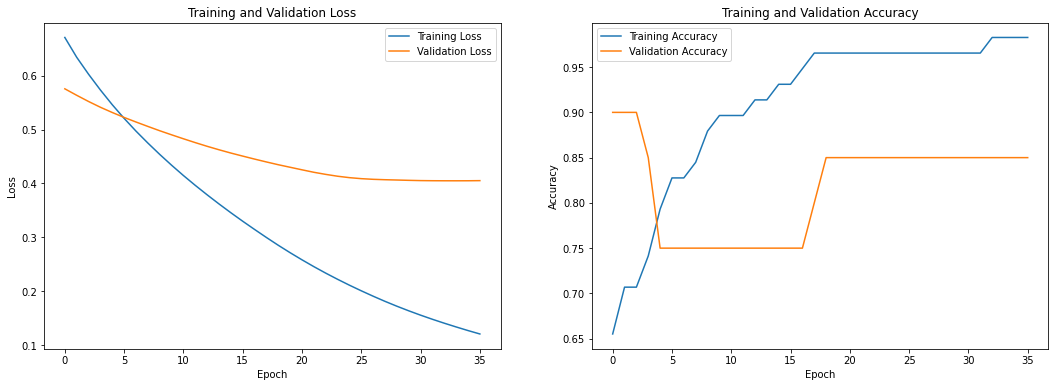

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plotear pérdida de entrenamiento y validación en el primer subplot
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotear precisión de entrenamiento y validación en el segundo subplot
ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Mostrar figura
plt.savefig('results/02_NeuralNetwork/NN_training.png', dpi=300,
            bbox_inches='tight')
plt.show()


### Model Performance Metrics

Using cross-validation techniques, the accuracy, precision, *recall*, and area under the curve (AUC) have been determined. These metrics provide valuable insights into the model's ability to generalize to new, unseen data during training.

Specifically, the *k-fold cross-validation* method was used, with 10 folds. This technique involves dividing the dataset into k random subsets (10 in this case). The model is then trained k times, each time using a different subset as the validation set and the remaining subsets as the training set. Finally, the performance metrics obtained in each iteration are averaged to provide a more robust estimate of the model's overall performance

In [10]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Get metrics with the best model with k-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=123)

accuracy = []
precision = []
recall = []
f1 = []
auc = []
confusion_matrices = []

for train_index, val_index in kf.split(data):
    # split
    X_train_fold, X_val_fold = data.iloc[train_index], data.iloc[val_index]
    y_train_fold, y_val_fold = response[train_index], response[val_index]
    # scale
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)
    # fit
    model_fold = Sequential()
    model_fold.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model_fold.add(Dense(32, activation='relu'))
    model_fold.add(Dense(1, activation='sigmoid'))
    model_fold.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    model_fold.fit(X_train_fold_scaled, y_train_fold, epochs=100, batch_size=32,
                   validation_data=(X_val_fold_scaled, y_val_fold), callbacks=[early_stopping],
                   verbose=0)
    # predict
    y_pred_fold = model_fold.predict(X_val_fold_scaled)
    y_pred_fold_class = (y_pred_fold > 0.5).astype('int32')
    # Get metrics
    accuracy.append(accuracy_score(y_val_fold, y_pred_fold_class))
    precision.append(precision_score(y_val_fold, y_pred_fold_class))
    recall.append(recall_score(y_val_fold, y_pred_fold_class))
    f1.append(f1_score(y_val_fold, y_pred_fold_class))
    auc.append(roc_auc_score(y_val_fold, y_pred_fold))
    confusion_matrices.append(confusion_matrix(y_val_fold, y_pred_fold_class))

print("Accuracy:", np.round(np.mean(accuracy), 3))
print("Precision:", np.round(np.mean(precision), 3))
print("Recall:", np.round(np.mean(recall), 3))
print("F1 score:", np.round(np.mean(f1), 3))
print("AUC:", np.round(np.mean(auc), 3))

Accuracy: 0.909
Precision: 0.917
Recall: 0.858
F1 score: 0.874
AUC: 0.945


Overall, the performance metrics for the neural network indicate that the model performs well, with an accuracy of 90.9%, precision of 91.7%, recall of 85.8%, F1 score of 87.4%, and an AUC of 0.945.

These results suggest that the model has effectively learned to distinguish between the two classes, achieving a high capacity for correct classification, accurately identifying both positive and negative classes.

However, the high AUC value (0.947) may indicate some level of overfitting. An AUC close to 1 might imply that the model is learning patterns too specific to the training dataset, which could negatively impact its performance on new, unseen data during training.

Below are the ROC curve and the confusion matrix for the model.

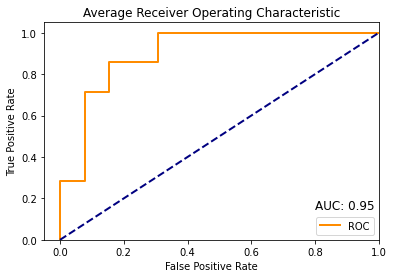

In [11]:
# ROC curve promedio
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test_scaled))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.text(0.8, 0.15, f'AUC: {np.mean(auc):.2f}', fontsize=12)
plt.savefig('results/02_NeuralNetwork/roc_curve.png', dpi=300,
            bbox_inches='tight')
plt.show()

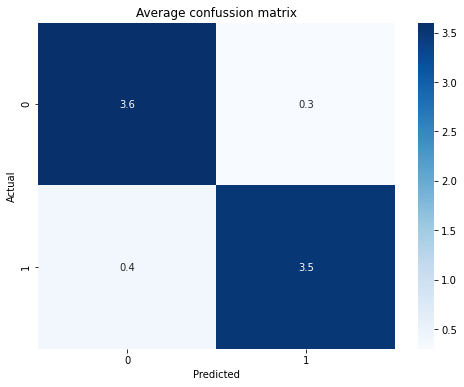

In [12]:
# Representar la matriz de confusión promedio
confusion_matrix_mean = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mean, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average confussion matrix')
plt.savefig('results/02_NeuralNetwork/confussion_matrix.png', dpi=300,
            bbox_inches='tight')
plt.show()